### Importing Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score,
                             classification_report, f1_score, precision_score, recall_score)
from sklearn.metrics import make_scorer, matthews_corrcoef
import warnings
warnings.filterwarnings('ignore')


### Data Preprocessing 

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

# Define column names based on dataset description
column_names = ['ID', 'Diagnosis'] + ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
                                      'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean',
                                      'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
                                      'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se',
                                      'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
                                      'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst',
                                      'fractal_dimension_worst']


# Load the dataset
data = pd.read_csv(url, header=None, names=column_names)

# Convert Diagnosis (B = Benign, M = Malignant) to numerical (0 = Benign, 1 = Malignant)
data["Diagnosis"] = data["Diagnosis"].map({"B": 0, "M": 1})
data.head(5)

,ID,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Feature Selection

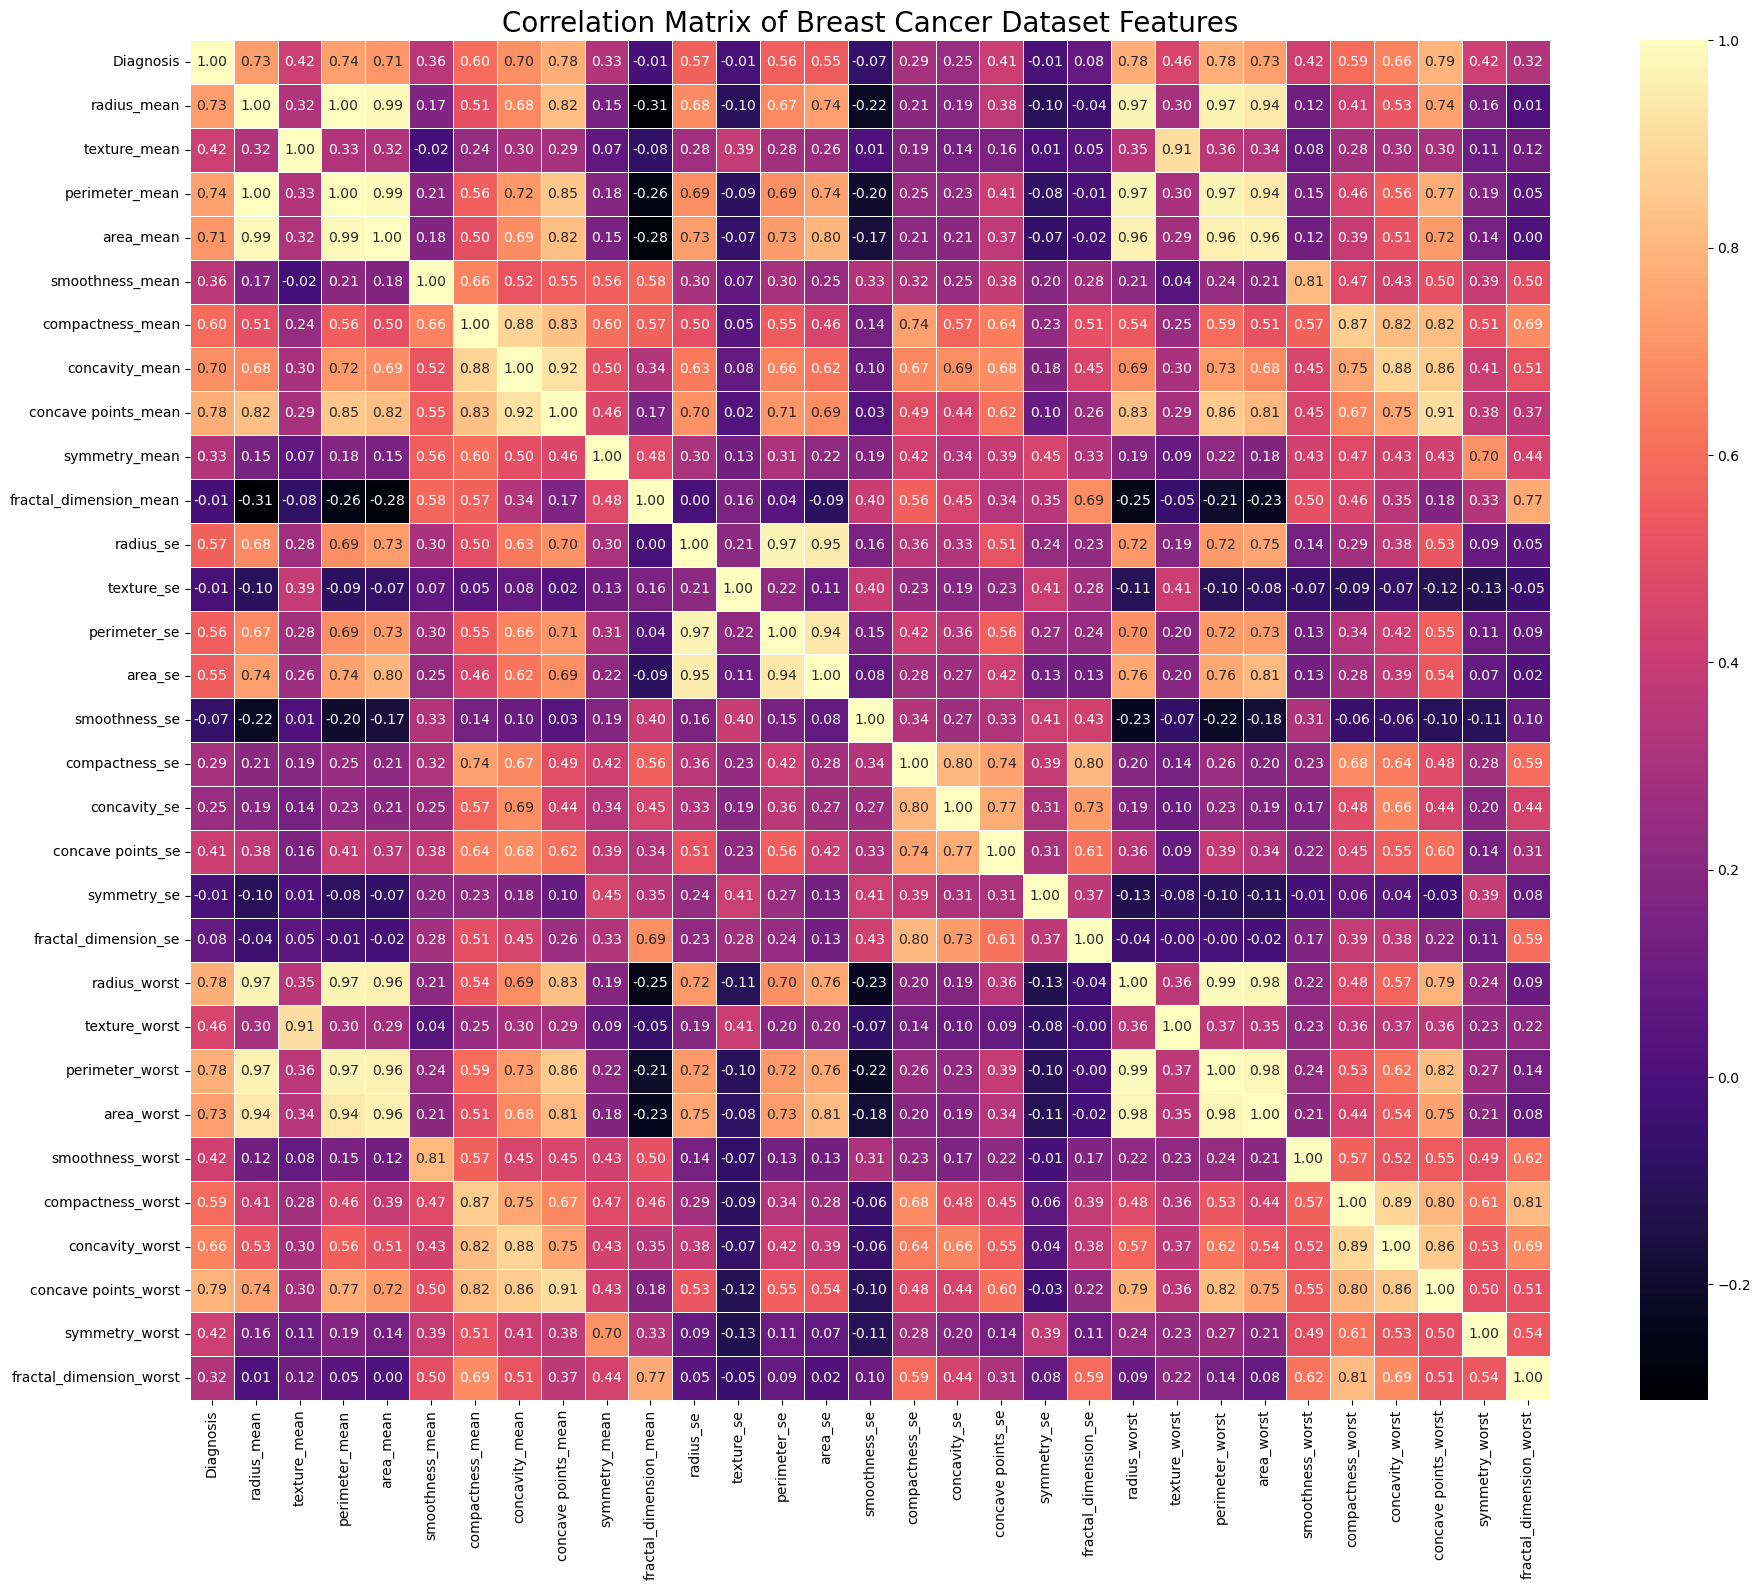

In [6]:
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
num_data = data[num_cols]


if 'ID' in num_data.columns:
    num_data = num_data.drop('ID', axis=1)

#checking correlation between features
corr_matrix = num_data.corr()

plt.figure(figsize=(20,16))
sns.heatmap(corr_matrix,
            cmap="magma",
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            cbar=True,
            square=True)
plt.title('Correlation Matrix of Breast Cancer Dataset Features', fontsize = 20)
plt.tight_layout()
plt.show()

In [7]:
#segregating highly correlated features
high_corr = np.where(np.abs(corr_matrix) > 0.9)
high_corr_list = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                  for x, y in zip(*high_corr) if x != y and x < y]
print("Highly Correlated Features (|correlation| > 0.9):")
for feature1, feature2, corr in high_corr_list:
    print(f"{feature1} - {feature2}: {corr}")

# Select Top 20 Features Based on Correlation with Diagnosis
top_features = corr_matrix['Diagnosis'].abs().sort_values(ascending=False).index[1:21]
print("Top 20 Features:", top_features.tolist())

Highly Correlated Features (|correlation| > 0.9):
radius_mean - perimeter_mean: 0.9978552814938106
radius_mean - area_mean: 0.9873571700566129
radius_mean - radius_worst: 0.9695389726112049
radius_mean - perimeter_worst: 0.9651365139559871
radius_mean - area_worst: 0.9410824595860461
texture_mean - texture_worst: 0.912044588840421
perimeter_mean - area_mean: 0.9865068039913908
perimeter_mean - radius_worst: 0.9694763634663146
perimeter_mean - perimeter_worst: 0.9703868870426395
perimeter_mean - area_worst: 0.9415498080023067
area_mean - radius_worst: 0.9627460860470841
area_mean - perimeter_worst: 0.9591195743552647
area_mean - area_worst: 0.9592133256498999
concavity_mean - concave points_mean: 0.921391026378859
concave points_mean - concave points_worst: 0.910155314298592
radius_se - perimeter_se: 0.9727936770160764
radius_se - area_se: 0.951830112110991
perimeter_se - area_se: 0.9376554069544158
radius_worst - perimeter_worst: 0.993707916102949
radius_worst - area_worst: 0.984014564

### Splitting the Data

In [9]:
X = data[top_features.tolist()] 
y = data["Diagnosis"]

# Split into 80% Training and 20% Holdout Data
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalize Training Data and Apply Same Transformation to Holdout Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

### Model Evaluation

In [11]:
mcc_metric = make_scorer(matthews_corrcoef)

cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tree_clf = DecisionTreeClassifier()
tree_params = {'classifier__max_depth': [2, 6, 12], 'classifier__min_samples_split': [2, 5, 10]}

knn_clf = KNeighborsClassifier()
knn_params = {'classifier__n_neighbors': [3, 5, 10], 'classifier__weights': ['uniform', 'distance']}

log_reg = LogisticRegression(solver='saga', max_iter=500)  
log_reg_params = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet'], 
    'classifier__C': [0.5, 5, 50],  
    'classifier__l1_ratio': [0.1, 0.5, 0.9]  
}

svm_clf = SVC(probability=True)
svm_params = {'classifier__C': [0.5, 5, 50], 'classifier__kernel': ['linear', 'rbf']}

# Define pipelines
tree_pipeline = Pipeline([('classifier', tree_clf)])
knn_pipeline = Pipeline([('classifier', knn_clf)])
log_reg_pipeline = Pipeline([('classifier', log_reg)])
svm_pipeline = Pipeline([('classifier', svm_clf)])

# Non-nested parameter search
tree_search = GridSearchCV(tree_pipeline, tree_params, scoring=mcc_metric, cv=cv_inner)
log_reg_search = GridSearchCV(log_reg_pipeline, log_reg_params, scoring=mcc_metric, cv=cv_inner)
knn_search = GridSearchCV(knn_pipeline, knn_params, scoring=mcc_metric, cv=cv_inner)
svm_search = GridSearchCV(svm_pipeline, svm_params, scoring=mcc_metric, cv=cv_inner)

# Nested CV with parameter optimization
tree_scores = cross_val_score(tree_search, X_train_scaled, y_train, cv=cv_outer)
log_reg_scores = cross_val_score(log_reg_search, X_train_scaled, y_train, cv=cv_outer)
knn_scores = cross_val_score(knn_search, X_train_scaled, y_train, cv=cv_outer)
svm_scores = cross_val_score(svm_search, X_train_scaled, y_train, cv=cv_outer)

# Store results
cv_results = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression', 'K-NN', 'SVM'],
    'Mean MCC': [tree_scores.mean(), log_reg_scores.mean(), knn_scores.mean(), svm_scores.mean()],
    'Std Dev': [tree_scores.std(), log_reg_scores.std(), knn_scores.std(), svm_scores.std()]
})
cv_results


,Model,Mean MCC,Std Dev
0,Decision Tree,0.847349,0.051426
1,Logistic Regression,0.935487,0.026534
2,K-NN,0.925605,0.045549
3,SVM,0.930401,0.024961


#### Model Selection & Hyperparameter Tuning  
- **Decision Tree:** Tuned `max_depth` and `min_samples_split` using grid search.  
- **k-NN:** Explored different values of `n_neighbors` and `weights`.  
- **Logistic Regression:** Applied **L1, L2, and ElasticNet regularization**.  
- **SVM:** Optimized `C` and `kernel` through grid search.  

#### Nested Cross-Validation  
- **Inner Loop:** Utilized `GridSearchCV` to determine the optimal hyperparameters.  
- **Outer Loop:** Employed `StratifiedKFold` to validate model performance on unseen data.  

#### Performance Evaluation  
- **Evaluation Metric:** **Matthews Correlation Coefficient (MCC)**.  
- **Model Comparison:** Assessed generalizability based on MCC scores.  


#### Observations:  
- The **model with the highest MCC score** demonstrates the best generalization.  
- **Logistic Regression with ElasticNet Regularization** consistently achieved high MCC and stability (low standard deviation).  
- **SVM and k-NN showed varied performance**, heavily influenced by hyperparameter tuning.  


### Conclusion  
- **Nested CV provides an unbiased assessment** while mitigating overfitting risks.  
- **Logistic Regression and k-NN** emerged as strong contenders.  
- Additional evaluation using **ROC curves, Lift curves, and Precision-Recall curves** can further refine model selection.  
- Based on the highest MCC score, **Logistic Regression** is identified as the best-performing model.  

### Model Selection with Hyper-parameters tuning 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max

      Metric     Score
0   Accuracy  0.982456
1  Precision  1.000000
2     Recall  0.952381
3   F1-Score  0.975610
4    ROC-AUC  0.996693
5        MCC  0.962622


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


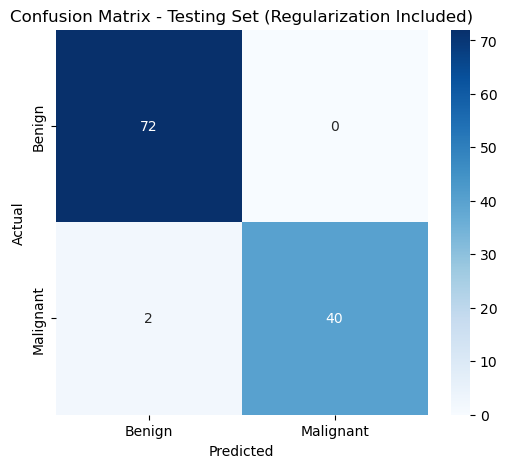

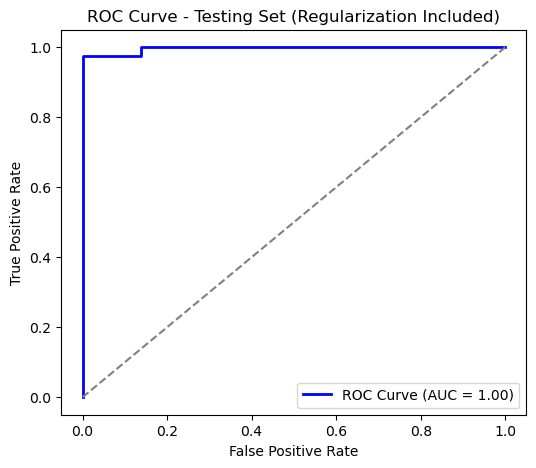

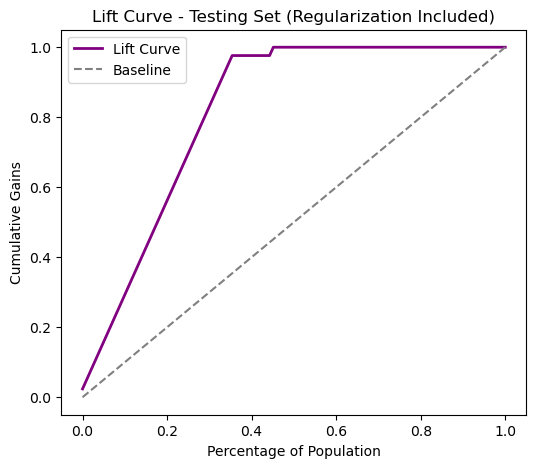

{'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}

In [14]:
mcc_metric = make_scorer(matthews_corrcoef)

hyperparam_grid = {
    'C': [0.05, 0.5, 50, 500],  
    'penalty': ['l1', 'l2', 'elasticnet'],  
    'solver': ['liblinear', 'saga']  
}

logreg_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=500), hyperparam_grid, cv=5, scoring=mcc_metric, n_jobs=-1)
logreg_search.fit(X_train_scaled, y_train)

# Model from validation tuning
best_logreg_model = logreg_search.best_estimator_

# Evaluate the Best Model on the holdout Dataset 
y_pred_holdout = best_logreg_model.predict(X_holdout_scaled)
y_prob_holdout = best_logreg_model.predict_proba(X_holdout_scaled)[:, 1]

# Compute Metrics for holdout Set
accuracy_holdout = accuracy_score(y_holdout, y_pred_holdout)
precision_holdout = precision_score(y_holdout, y_pred_holdout)
recall_holdout = recall_score(y_holdout, y_pred_holdout)
f1_holdout = f1_score(y_holdout, y_pred_holdout)
conf_matrix_holdout = confusion_matrix(y_holdout, y_pred_holdout)
mcc_holdout = matthews_corrcoef(y_holdout, y_pred_holdout)

# Compute ROC Curve for holdout Set
roc_auc_holdout = roc_auc_score(y_holdout, y_prob_holdout)
fpr_holdout, tpr_holdout, _ = roc_curve(y_holdout, y_prob_holdout)

# Compute Precision-Recall Curve for holdout Set
precision_vals_holdout, recall_vals_holdout, _ = precision_recall_curve(y_holdout, y_prob_holdout)
pr_auc_holdout = auc(recall_vals_holdout, precision_vals_holdout)

# Compute Lift Curve for holdout Set
sorted_indices_holdout = np.argsort(y_prob_holdout)[::-1]
sorted_labels_holdout = np.array(y_holdout)[sorted_indices_holdout]
cumulative_gains_holdout = np.cumsum(sorted_labels_holdout) / np.sum(sorted_labels_holdout)
baseline_holdout = np.linspace(0, 1, len(y_holdout))

# Display metrics including MCC
holdout_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'MCC'],
    'Score': [accuracy_holdout, precision_holdout, recall_holdout, f1_holdout, roc_auc_holdout, mcc_holdout]
})

print(holdout_metrics)

# Plot Confusion Matrix for holdout Set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_holdout, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Testing Set (Regularization Included)')
plt.show()

# Plot ROC Curve for holdout Set
plt.figure(figsize=(6, 5))
plt.plot(fpr_holdout, tpr_holdout, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_holdout:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Testing Set (Regularization Included)')
plt.legend()
plt.show()

# Plot Lift Curve for holdout Set
plt.figure(figsize=(6, 5))
plt.plot(np.linspace(0, 1, len(y_holdout)), cumulative_gains_holdout, color='purple', lw=2, label='Lift Curve')
plt.plot(np.linspace(0, 1, len(y_holdout)), baseline_holdout, color='gray', linestyle='--', label='Baseline')
plt.xlabel('Percentage of Population')
plt.ylabel('Cumulative Gains')
plt.title('Lift Curve - Testing Set (Regularization Included)')
plt.legend()
plt.show()

logreg_search.best_params_


### ROC Curve  
#### Key Takeaways:  
- The model achieved a **perfect AUC score of 1.00**, meaning it distinguishes between classes flawlessly.  
- A **high AUC (>0.90)** indicates strong performance in separating benign and malignant cases.  
- The curve’s **proximity to the top-left corner** shows its excellent classification power.  

### Lift Curve  
#### Key Takeaways:  
- A **steeper curve** suggests the model is highly effective at identifying high-risk cases early.  
- The **cumulative gains curve staying well above the baseline** means the model prioritizes high-risk cases efficiently.  
- An **ideal model** would show a sharp early rise, capturing most malignant cases with minimal data.  

### Final Thoughts  
- **Logistic Regression with L2 Regularization** performed exceptionally well, delivering **high ROC-AUC and MCC scores**.  
- The **ROC Curve confirms its strong ability to distinguish between benign and malignant cases**.  
- The **Lift Curve highlights its practical value in early cancer detection**, a crucial factor in medical applications.  
- To refine performance further, we could explore **feature selection, ElasticNet regularization, and fine-tuning hyperparameters** for even better results.